# 뉴스 요약봇 만들기

# Step1. 라이브러리 불러오기

In [2]:
import nltk
nltk.download('stopwords')

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step2. 데이터 수집하기
데이터는 뉴스 기사 데이터를 사용하겠습니다.

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.sample(10)

,headlines,text
20918,Bihar minister rejects demand for resignation ...,Bihar Urban Development Minister Suresh Kumar ...
97039,80% of former MPs are crorepatis: Supreme Court,The Supreme Court has saidÃ¢ÂÂ nearly 80% of...
9710,Google parent halts glucose-detecting contact ...,Google parent Alphabet's life sciences divisio...
48044,Hold elections to form complaints committee: D...,The Delhi University (DU) has written to all c...
69527,Teen who climbed peak in Superman underwear ge...,"A 19-year-old who completed the 1,085-metre cl..."
83772,Chipmaker puts itself on sale after Apple ends...,iPhone graphics chip supplier Imagination Tech...
17723,Spain hand World Cup 2018 runners-up their wor...,The Spanish national football team handed Croa...
97983,Man sues daughter for Ã¢ÂÂ¹17L for taking too...,An Austrian man has sued his daughter for Ã¢Â...
45899,Swamy accuses Shashi Tharoor of saying he is n...,BJP MP Subramanian Swamy has questioned if Con...
87288,SRK's wife Gauri posts pic of son AbRam with d...,Actor Shah Rukh Khan's wife Gauri Khan took to...


In [4]:
data.shape

(98401, 2)

# Step3. 데이터 전처리하기(추상적 요약)
## 1. 중복치 & 결측치 제거

In [5]:
# 중복을 배제한 샘플의 수를 셈니다.
print(data['headlines'].nunique())
print(data['text'].nunique())

98280
98360


원래 샘플의 수인 98401과 차이가 있는거보니 중복치가 있네요. 여기서 headlines는 text의 요약본이기때문에 text가 달라도 headlines은 동일할 수도 있습니다. 하지만 text자체가 중복이 되면 중복샘플이므로 제거하겠습니다.

In [6]:
data.drop_duplicates(subset = ['text'], inplace=True)
len(data)

98360

이제 결측치가 있는지 확인해보겠습니다.

In [7]:
(data.isnull()).sum()

headlines    0
text         0
dtype: int64

결측치는 없습니다.

## 2. 텍스트정규화와 불용어 제거
텍스트 정규화를 위한 **사전**을 다음과 같이 구성하겠습니다.

In [8]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


상황에따라 불용어를 제거하는것이 자연어 처리의 성능을 높일수있습니다. 불용어도 한번 출력해보겠습니다.

In [9]:
print(stopwords.words('english'))
print(len(stopwords.words('english')))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

그리고 요약결과문이 자연스러운 문장이 되려면 이 불용어들이 headlines에는 남아있는게 더 좋습니다.

## 3. 전처리함수 구현

In [10]:
def preprocess_sentence(sentence, remove_stopwords=True):
  sentence = sentence.lower() # 텍스트 소문자화
  sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
  sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열( )제거
  sentence = re.sub('"','', sentence) # 쌍따옴표 제거
  sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
  sentence = re.sub(r"'s\b","", sentence) # 소유격 제거, Ex) roland's -> roland
  sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어어 외외 문자 공백으로 변환
  sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경경

  # 불용어 제거
  if remove_stopwords:
    tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
  # 불용어 미제거
  else:
    tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
  return tokens   

## 4. 훈련데이터 전체에 전처리 적용하기

In [11]:
clean_text = []

for s in data['text']:
  clean_text.append(preprocess_sentence(s))

print('text 전처리 후 결과',clean_text[:5])

text 전처리 후 결과 ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure 

In [12]:
clean_headlines = []

for s in data['headlines']:
  clean_headlines.append(preprocess_sentence(s, False)) # 

print('headlines 전처리 후 결과:', clean_headlines[:5])

headlines 전처리 후 결과: ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


이렇게 전처리 과정을 거친후 빈샘플이 생겼는지 확인해봐야합니다. 왜냐하면 전처리 이후 문장의 모든 단어가 사라지는 경우가 있기 때문입니다. 

In [13]:
# 전처리한 데이터를 다시 데이터프레임에 넣어줍니다.
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

# Null값 확인
print('Nomber of Null:',data.isnull().sum())

# Null 제거
data.dropna(axis=0, inplace=True)
print('Null 제거후 전체 샘플수:', len(data))

Nomber of Null: headlines    0
text         0
dtype: int64
Null 제거후 전체 샘플수: 98360


## 5. 샘플의 최대 길이 정하기
이제 훈련에 사용할 샘플의 최대 길이를 정해줍시다.

text와 headlines의 최대,최소,평균길이를 구하고 시각화해보겠습니다.

text의 최소길이: 1
text의 최대길이: 60
text의 평균길이: 35.09968483123221
headlines의 최소길이: 1
headlines의 최대길이: 16
headlines의 평균길이: 9.299532330215534


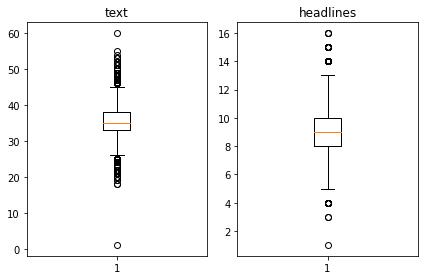

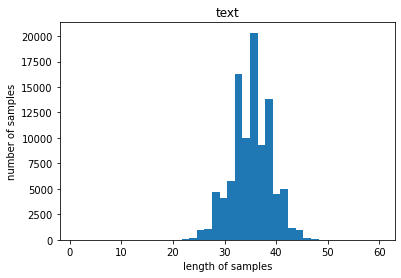

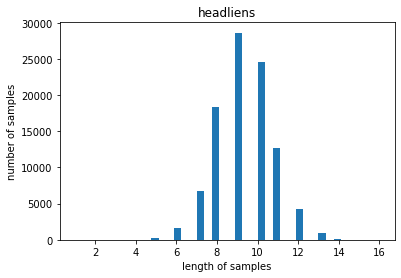

In [14]:
# text와 headlines의 문장 길이 분포리스트
text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('text의 최소길이: {}'.format(np.min(text_len)))
print('text의 최대길이: {}'.format(np.max(text_len)))
print('text의 평균길이: {}'.format(np.mean(text_len)))
print('headlines의 최소길이: {}'.format(np.min(headlines_len)))
print('headlines의 최대길이: {}'.format(np.max(headlines_len)))
print('headlines의 평균길이: {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headliens')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

이로부터 text의 최대길이와 headlines의 적절한 최대길이를 임의로 정해보겠습니다.

In [15]:
text_max_len = 40
headlines_max_len = 10

그리고 이 길이를 택했을때, 해당 데이터의 몇%가 해당하는지 계산하는 함수를 만들어서보겠습니다.

In [16]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
      cnt += 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8162972753151687


이 상태로 40과 10으로 패딩을 하게 되면 해당 길이보다 긴 샘플은 내용이잘리게 됩니다. 따라서 우리는 정해진 길이로 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 전처리하겠습니다.

In [17]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수:', len(data))

전체 샘플수: 74102


## 6. 시작토큰과 종료토큰 추가하기
seq2seq훈련을 위해서는 디코더의 입력과 레이블에 각각 시작토큰과 종료토큰을 추가할 필요가 있어요.

이번실습에서는 시작토큰을 \<sos\>, 종료토큰은 \<eos\>이라 임의로 명명하고 앞,뒤로 추가하겠습니다.

In [18]:
data['decoder_input'] = data['headlines'].apply(lambda x: '<sos> '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x: x + ' <eos>')
data.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,<sos> new zealand end rohit sharma led india m...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,<sos> aegon life iterm insurance plan helps cu...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,<sos> rahat fateh ali khan denies getting noti...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,<sos> cong wins ramgarh bypoll in rajasthan ta...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,<sos> up cousins fed human excreta for friends...,up cousins fed human excreta for friendship wi...


이제 인코더의 입력, 디코더의 입력과 레이블을 각각 numpy타입으로 저장해주겠습니다.

In [19]:
encoder_input = np.array(data['text'])
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

## 7. 훈련데이터와 테스트데이터 분리

In [20]:
# 전체 샘플수와 같은 크기의 순서가 섞인 정수 시퀀스를 만들어줍니다.
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

# 정수 시퀀스를 이용해 데이터 샘플 순서를 섞어줍시다
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 8:2의 비율로 분리
n_of_val = int(len(encoder_input)*0.2)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('인코더인풋_훈련 개수:', len(encoder_input_train))
print('디코더인풋_훈련 개수:', len(decoder_input_train))
print('인코더인풋_테스트 개수:', len(encoder_input_test))
print('디코더인풋_테스트 개수:', len(decoder_input_test))

인코더인풋_훈련 개수: 59282
디코더인풋_훈련 개수: 59282
인코더인풋_테스트 개수: 14820
디코더인풋_테스트 개수: 14820


## 8. vocabulary만들기
기계가 텍스트를 처리하려면 모든 데이터의 단어들을 모두 정수로 바꾸어주어야합니다. 이 과정을 vocabulary을 만든다고합니다. 

우선 encoder_input_train에 대한 vocabulary를 만들어봅시다.

In [21]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

이제 단어집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었습니다. 현재 생성된 단어집합은 word_index에 저장되어있습니다. 하지만 이렇게 만든 vocabulary에 있는 모든 단어를 다 사용하는것은 비효율적입니다.

등장 빈도수가 7회 미만인 단어들이 데이터에서 얼만큼의 비중을 차지하는지 확인해봅시다.

In [22]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0  # 등장 빈도수가 7보다 작은 단어의 개수를 카운드
total_freq = 0  # 훈련데이터의 전체 단어 빈도수 총 합
rare_freq = 0  # 등장빈도수가 7보다 작은 단어의 등장 빈도수의 총 합

# word_counts()에는 각 단어의 등장빈도수가 저장돼 있습니다.
for key, value in src_tokenizer.word_counts.items():
  total_freq += value

  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('vocabulary의 크기:', total_cnt)
print('등장 빈도 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('vocabulary에서 희귀단어를 제외시킬 경우의 vocabulary의 크기%s'%(total_cnt - rare_cnt))
print('vocabulary에서 희귀단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체 등장빈도에서 희귀단어 등장빈도 비율:', (rare_freq / total_freq)*100)

vocabulary의 크기: 61398
등장 빈도 6번 이하인 희귀 단어의 수: 42122
vocabulary에서 희귀단어를 제외시킬 경우의 vocabulary의 크기19276
vocabulary에서 희귀단어의 비율: 68.60484054855208
전체 등장빈도에서 희귀단어 등장빈도 비율: 4.185278226048331


7회미만 단어들은 vocabulary의 68%를 차지하지만 등장비중은 4%밖에 되지않네요.따라서 훈련데이터에서 해당단어들을 제거하겠습니다.

In [23]:
src_vocab = 19000
src_tokenizer = Tokenizer(num_words=src_vocab) # vocabulary의 크기를 19000으로제한
src_tokenizer.fit_on_texts(encoder_input_train) # vocabulary 재생성

## 9. 정수 인코딩
생성된 vocabulary를 기반하여 텍스트데이터들을 모두 정수로 변환하는 정수인코딩을 수행해보겠습니다.

In [24]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

print(encoder_input_train[:3])

[[24, 2143, 2720, 13736, 4481, 72, 7918, 15069, 1580, 855, 3229, 1125, 740, 2143, 2132, 4481, 4075, 23, 365, 3230, 11714, 2650, 7918, 15069, 58, 8836, 437, 9774, 1759, 408, 2], [3, 2361, 7919, 5024, 1664, 9031, 408, 2685, 682, 88, 642, 6330, 24, 1206, 275, 243, 1952, 2361, 1664, 3325, 1979, 355, 2956, 12665, 3717, 745, 2307, 15892], [6248, 8650, 1264, 8837, 646, 344, 592, 128, 575, 128, 457, 420, 5394, 646, 5464, 446, 139, 13737, 2218, 611, 94, 6248, 704, 127, 4566, 47, 8838, 578, 3283]]


동일한 과정을 headlines에 대해서도 수행하겠습니다. 

In [25]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index)
rare_cnt = 0
total_freq = 0
rare_freq = 0

for key, value in tar_tokenizer.word_counts.items():
  total_freq += value

  if(value < threshold):
    rare_cnt += 1
    rare_freq += value

print('vocabulary의 크기:', total_cnt)
print('등장빈도가 %s번 이하인 희귀 단어의수 : %s'%(threshold - 1, rare_cnt))
print('vocabulary에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print('vocabulary에서 희귀 단어의 비율:', (rare_cnt / total_cnt)*100)
print('전체등장빈도에서 희귀단어 등장 빈도비율:', (rare_freq / total_freq)*100)

vocabulary의 크기: 27310
등장빈도가 5번 이하인 희귀 단어의수 : 18300
vocabulary에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9010
vocabulary에서 희귀 단어의 비율: 67.00842182350787
전체등장빈도에서 희귀단어 등장 빈도비율: 6.003340434187781


vocabulary의 크기를 9000으로 제한하겠습니다.

In [26]:
tar_vocab = 9000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

print('input', decoder_input_train[:3])
print('target', decoder_target_train[:3])

input [[1, 2931, 3, 1338, 2597, 94, 8183, 33, 6509, 4, 43], [1, 3830, 167, 34, 957, 4, 1359, 205, 3, 194], [1, 4285, 3693, 18, 1238, 9]]
target [[2931, 3, 1338, 2597, 94, 8183, 33, 6509, 4, 43, 2], [3830, 167, 34, 957, 4, 1359, 205, 3, 194, 2], [4285, 3693, 18, 1238, 9, 2]]


패딩으로 넘어가기전에 한가지 점검해야할것이있습니다.\
전체데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈샘플이 되었을 가능성이 있어요. 여기서 주의할점은 토큰때문에 길이가0이된 요약문의 실제길이는 1로 나오게됩니다. 훈련,테스트 데이터에서 길이가 1인데이터들을 삭제해 줍시다.

In [27]:
# 길이가 1인 문장의 인덱스를 리스트로 저장해줍니다.
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련데이터의 개수:', len(drop_train))
print('삭제할 테스트데이터의 개수:', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수:', len(encoder_input_train))
print('훈련 레이블의 개수:', len(decoder_input_train))
print('테스트데이터의 개수:', len(encoder_input_test))
print('테스트레이블의 개수:', len(decoder_input_test))

삭제할 훈련데이터의 개수: 0
삭제할 테스트데이터의 개수: 1
훈련 데이터의 개수: 59282
훈련 레이블의 개수: 59282
테스트데이터의 개수: 14819
테스트레이블의 개수: 14819


## 10. 패딩하기
패딩은 pre로 두겠습니다.

In [28]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')

decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='pre')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='pre')

decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='pre')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='pre')

드디어 전처리가 끝났습니다.
# Step4. 모델 설계하기(추상적요약)
먼저 인코더를 설계해보겠습니다.

In [29]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더 설계
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

이제 디코더를 설계해봅시다!

In [30]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 출력층을 설계해봅시다.

In [31]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

# Step5. 어텐션 메커니즘 사용하기(추상적요약)
지금까지 설계한것은 가장 기본적인 seq2seq입니다. 그런데 디코더의 출력층 설계를 살짝 바꿔서 성능을 높일 수 있는 방법이 있습니다.\
여기서는 이미 구현된 어텐션함수를 가져와서 디코더의 출력층에 결합시켜주겠습니다. 참고로 여기서 사용하는 어텐션 함수는 Bahdanau스타일의 어텐션입니다.

어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해봅시다.

In [32]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [33]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      2432000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 40, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

# Step6. 모델 훈련하기(추상적 요약)
설계한 모델을 가지고 훈련을 진행해보겠습니다.

In [34]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 36s 100ms/step - loss: 6.2403 - val_loss: 5.8451
Epoch 2/50
232/232 [==============================] - 22s 94ms/step - loss: 5.8930 - val_loss: 5.7429
Epoch 3/50
232/232 [==============================] - 22s 96ms/step - loss: 5.7713 - val_loss: 5.6436
Epoch 4/50
232/232 [==============================] - 22s 96ms/step - loss: 5.6497 - val_loss: 5.5350
Epoch 5/50
232/232 [==============================] - 23s 97ms/step - loss: 5.5157 - val_loss: 5.4261
Epoch 6/50
232/232 [==============================] - 23s 98ms/step - loss: 5.3870 - val_loss: 5.3480
Epoch 7/50
232/232 [==============================] - 23s 99ms/step - loss: 5.2780 - val_loss: 5.2599
Epoch 8/50
232/232 [==============================] - 23s 99ms/step - loss: 5.1581 - val_loss: 5.1515
Epoch 9/50
232/232 [==============================] - 23s 100ms/step - loss: 5.0312 - val_loss: 5.0702
Epoch 10/50
232/232 [==============================] - 23s 101ms/step - loss: 4.

이제 훈련데이터의 손실과 검증데이터의 손실이 줄어드는 과정을 시각화해봅시다.

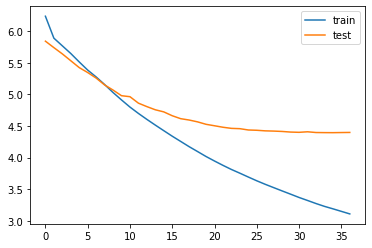

In [35]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# Step7. 모델 테스트하기(추상적요약)
테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해둡니다.

In [48]:
src_index_to_word = src_tokenizer.index_word
tar_word_to_index = tar_tokenizer.word_index
tar_index_to_word = tar_tokenizer.index_word

테스트 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야하기 때문에 부득이하게 테스트를 위한 모델 설계를 별도로 해주어야 합니다.

In [37]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기상태를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

이제 어텐션 메커니즘을 사용하는 출력층을 설계합니다.

In [38]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

단어 문장을 만들어주는 함수를 구현합니다.

In [54]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sos']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eos'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eos'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들어보겠습니다.

In [57]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sos']) and i!=tar_word_to_index['eos']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

테스트 데이터 약 50개의 샘플에 대해서 실제요약과 예측된 요약을 비교해봅시다.

In [59]:
for i in range(90, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : ten vip ticket holders volunteered implanted hands three day pass pause fest technology fest held australia february implanted volunteers chips also programmed unlock door volunteer home gym workplace 
실제 요약 : volunteers get implant for entry to tech fest 
예측 요약 :  new zealand to host its st ever in years


원문 : indian cricketer ms dhoni seen offering prayers ranchi temple fourth day navratri dhoni sought blessings deity arrived temple car year old offered visit temple leading chennai super kings ipl title earlier 
실제 요약 : dhoni offered prayers at ranchi temple on th navratri day 
예측 요약 :  aus player gets life term for his wife celebration


원문 : rajinikanth promised sponsor higher education class boy erode returned police wallet containing notes found road leading school adding today age people cheat kill even little money rajinikanth praised yasin saying honesty great quality 
실제 요약 : rajinikanth to sponsor education of boy who returned 
예측 요약 :  man who was up to police for fre

# Step8. Summa을 이용해서 추출적 요약해보기(추출적요약)
패키지 Summa에서는 추출적요약을 위한 모듈인 summarize를 제공하고있습니다.

In [ ]:
!pip install summa

Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아봅시다.
- text : 요약할 텍스트
- ratio : 원본에서 선택되는 문장 비율. 0~1사이값
- words : 출력에 포함할 단어 수
- split : True면 문장list / False면 조인된 문자열을 반환

summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행합니다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요.

In [195]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [198]:
# 원래문장
data['text'][5]

'Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India. "It would have been better if the authorities would have served the notice first if any and then publicised this," reads a press release issued on behalf of Rahat. The statement further called the allegation "bizarre".'

In [197]:
# 요약한 문장1
from summa.summarizer import summarize
print(summarize(data['text'][5], ratio=0.35))

Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.


In [201]:
# 요약한 문장2
summarize(data['text'][5], words=20)

'Pakistani singer Rahat Fateh Ali Khan has denied receiving any notice from the Enforcement Directorate over allegedly smuggling foreign currency out of India.'

# 회고
- 이번 실습에서는 뉴스기사를 두가지 방식으로 요약해보았다. 첫번째는 추상적요약이고, 두번째는 추출적요약이었다. 추상적요약은 특히 전처리가 상당히 길고 까다로웠다. 거의 대부분은 전처리로 시간을 썼다..
- 그리고 훈련을 진행했는데 val loss가 4.39가나왔다. 그래서그런지 요약된 문장을 보면 도통 무슨말을 하는지 알 수가 없다
- 마지막으로 추출적 요약을 진행했는데, 처음 진행할때는 계속 빈칸이 나왔었다. 그래서 한참을 헤메다가 알아차렸는데 summa의 summarize()에 문장을 넣어줄때 해당문장이 전처리가된 문장이 아닌 원래의 문장을 넣어주어야하는것이었다. 전처리된 문장을 넣어주니까 계속 빈칸이 출력이됐었다가 원문장을 넣어주니 정상적으로 출력이되었다. 하지만 문장자체가 200~300길이로된 짧은 문장이라 그런지 제대로된 요약이아니라 그냥 전체문장 일부분을 잘라서 그대로 들고온것이라 사실상 요약이 잘 안됬다고 볼 수 있다.